In [1]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ergodicpy as ep
import scipy as sp
from scipy.stats import chi2_contingency

SAVE_FIGURES = False
x_points = 20

In [469]:
def rn(hists):
    """ Row normalize """
    hists = np.array(hists)
    return (hists/hists.sum(axis=1)[:, np.newaxis])
    
def grid(rs):
    return [(0, 0), (1, int(len(rs)/2)), (2, -1)]
    
def plot_hists(func, xs, hs, hue_label='h'):
    """ Plots the heatmaps """
    fig, axes = plt.subplots(3, 3, figsize=(10,10))
    for ix, x in grid(xs):
        for ih, h in grid(hs):
            hists = func(xs[x], hs[h])
            g = sns.heatmap(data=hists, ax=axes[ih][ix])
            g.set_title("x=%s, %s=%s" % (xs[x], hue_label, hs[h]))
    
    
def plot(data, x='x', hue='hue'):
    """ Plots Chi2 Tau2 """
    d = data[0].copy()
    del d[x]
    del d[hue]
    
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10,10))
    df = pd.DataFrame(data)
    # chi2
    g = sns.lineplot(data=df, x=x, y='chi2', ax=axes[0][0], hue=hue)
    g.set(title='Chi2', ylabel=None)
    
    g = sns.lineplot(data=df, x=x, y='chi2_p', ax=axes[0][1], hue=hue, legend=False)
    axes[0][1].axhline(y=0.05, color='grey', linestyle='dotted')
    g.set(ylim=(-0.05,1.05), title='Chi2 p-value', ylabel=None)
    
    # ce
    #g = sns.lineplot(data=df, x=x, y='cex', ax=axes[1][0], hue=hue, legend=False)
    #g.set(title='Ergodic Complexity * states (Ce*b)', ylabel=None)
    
    #g = sns.lineplot(data=df, x=x, y='cep', ax=axes[1][1], hue=hue, legend=False)
    #axes[1][1].axhline(y=0.05, color='grey', linestyle='dotted')
    #g.set(ylim=(-0.05,1.05), title='Ergodic Complexity * states p-value', ylabel=None)
    
    # ce
    g = sns.lineplot(data=df, x=x, y='tau2', ax=axes[1][0], hue=hue, legend=False)
    g.set(title='Tau2', ylabel=None)
    
    g = sns.lineplot(data=df, x=x, y='tau2_p', ax=axes[1][1], hue=hue, legend=False)
    axes[1][1].axhline(y=0.05, color='grey', linestyle='dotted')
    g.set(ylim=(-0.05,1.05), title='Tau2 p-value', ylabel=None)
    
    return fig

def compare(x_range, hue_range, hist_func, hue_label, name=None, boost=None, hist_plot=True, flat_weights=False):
    data = []
    for hue in hue_range:
        for x in x_range:
            hists = hist_func(x, hue)
            
            # change default weight behaviour
            if flat_weights:
                weights = np.ones(len(hists))
            else:
                weights = None
            
            # analyse
            measures = ep.measures(hists, boost=boost, weights=weights, with_meta=True)
            chi2, p, _, _ = sp.stats.chi2_contingency(hists)

            # store
            data.append({
                'chi2': chi2,
                'chi2_p': p,
                'tau2': measures['tau2'],
                'tau2_p': measures['tau2p'],
                'x': x,
                hue_label : hue,
            })
    
    fig = plot(data, hue=hue_label)
    if SAVE_FIGURES and name is not None:
        fig.savefig("figures/%s.eps" % name)
    
    if hist_plot:
        plot_hists(hist_func, x_range, hue_range, hue_label)

# Observations count

- Tau2 is absolutely invariant to the number of observations
- While for _Chi2 p_ the fewer the observations, the less confident it is about being heterogenious

Each of the following is a pmf, where the x value makes the sample set more heterogenious (aka ergodically complex). Then the ensemble is multiplied by the outlined number of observations.

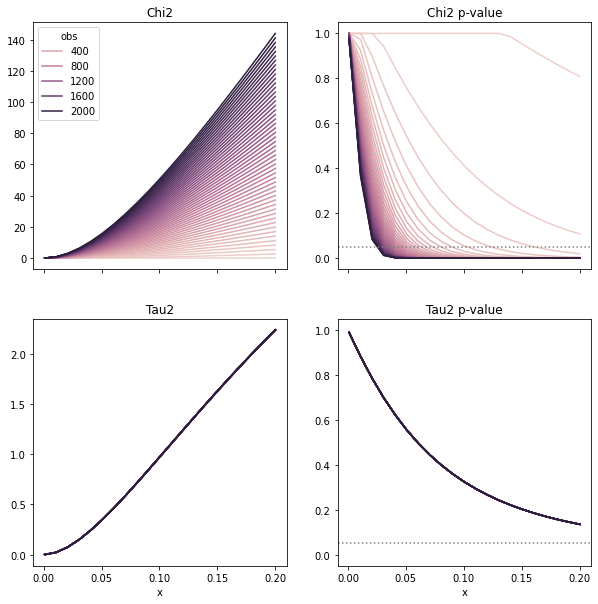

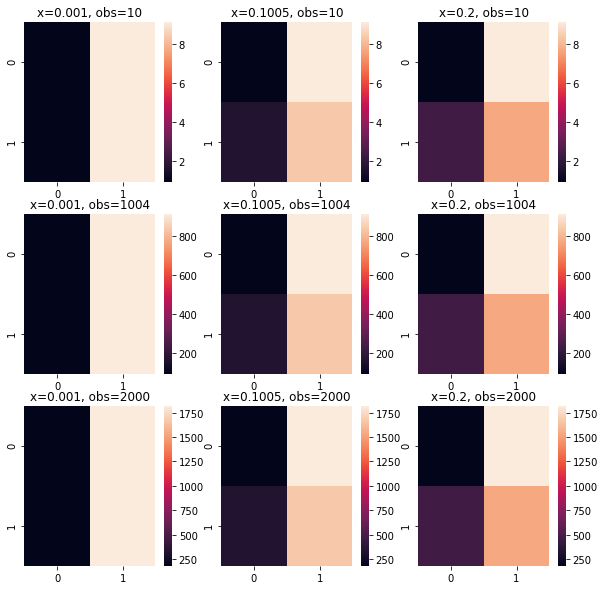

In [471]:
compare(ep.binspace(0.001,0.2,x_points), ep.binint(10,2000,50), lambda x, h: rn(np.array([[0.1,1],[0.1+x,1]]))*h, 'obs')

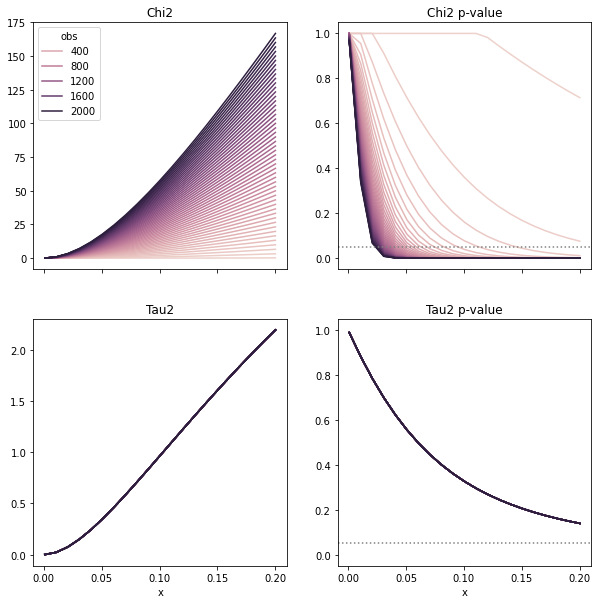

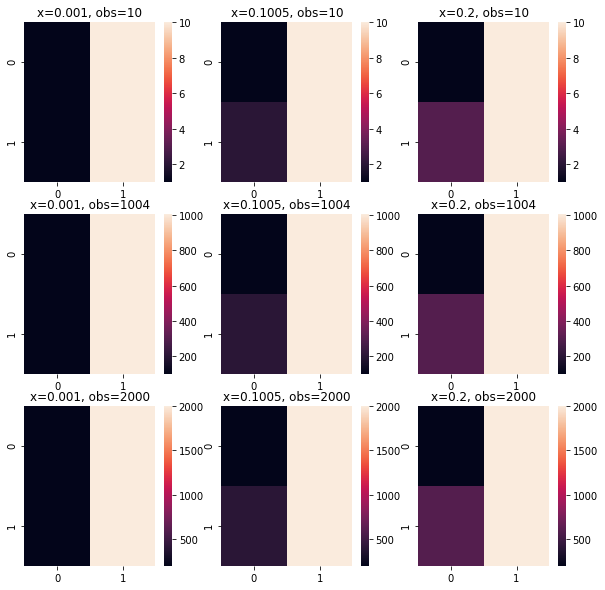

In [472]:
compare(ep.binspace(0.001,0.2,x_points), ep.binint(10,2000,50), lambda x, h: np.array([[0.1,1],[0.1+x,1]])*h, 'obs')

An alternative distribution

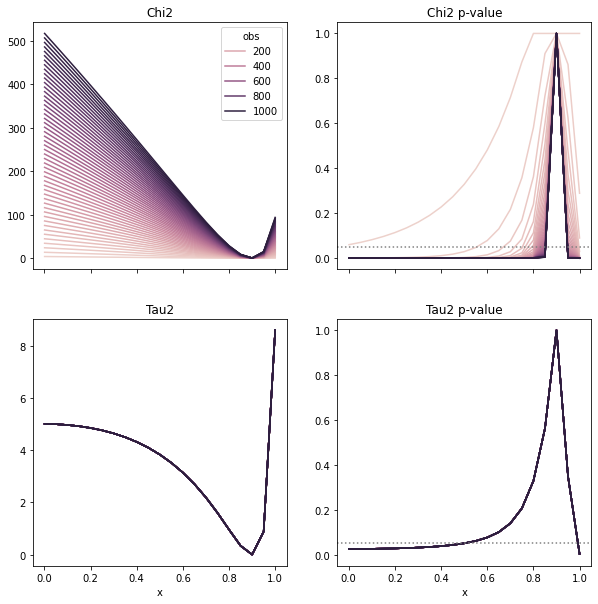

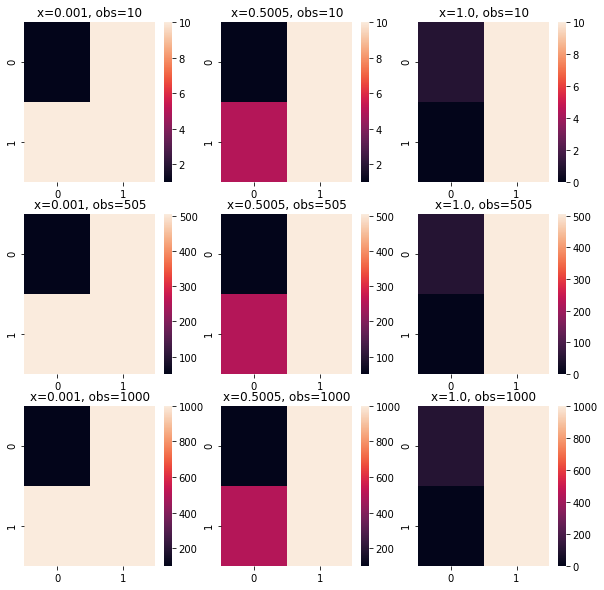

In [473]:
compare(ep.binspace(0.001,1.0,x_points), ep.binint(10,1000,50), lambda x, h: np.array([[0.1,1],[1-x,1]])*h, 'obs')

# Weighted

- Chi2 has a weighting mechanism built in as it uses raw frequency data
- Tau2 uses weights, which is similar to adjusting the frequency of a particular row
- The default weights are the sum of the observations for that ensemble row (N_k) by the total observations across all ensembles (N_k/N)

In [11]:
def weighted_hist(x, h):
    hists = np.array([[h,h],[1+x,1]]) # just focus on absolute difference between ensembles
    hists /= hists.sum() # normalise to account for obs count differences
    return hists*80 # have to multiply by a decent obs count as chi2 sensitive to absolute obs

def weighted_hist_not_norm(x, h):
    hists = np.array([[h,h],[1+x,1]])
    return hists*10

print(weighted_hist(0.1,10))
print(weighted_hist_not_norm(0.1,10))

[[36.19909502 36.19909502]
 [ 3.98190045  3.6199095 ]]
[[100. 100.]
 [ 11.  10.]]


- Here Chi2 & Tau2 behave similarly
- Here we compare histograms with an increasing difference in the absolute counts across ensmebles
- Meaning the flat ensemble becomes more dominant
- In reality this could be because either that ensemble is easier to get data for therefore the absolute counts are higher or it could be biases in sampling etc
- Chi2 & Tau2 (by default) take these differences into account in the same way, assuming that ensembles with smaller absolute counts exist less in the world and therefore contribute to the heterogenity of the system less also

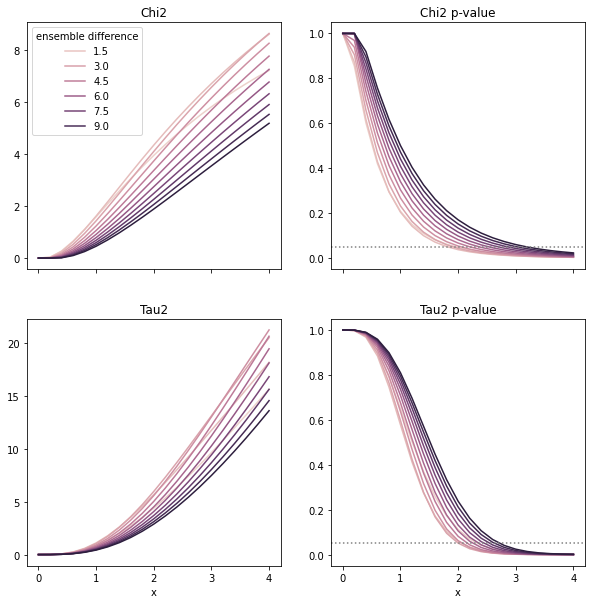

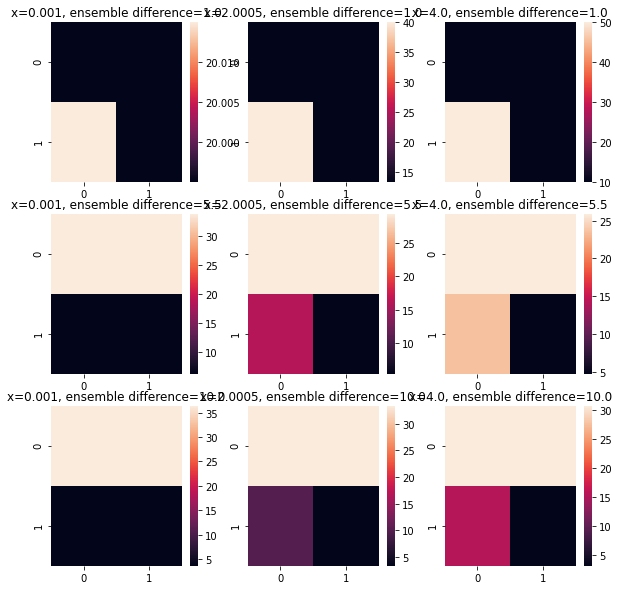

In [81]:
compare(ep.binspace(0.001,4,x_points), ep.binspace(1,10,10), weighted_hist, 'ensemble difference')

However, with Tau2 this assumed behaviour can be turned off by setting the weights to all be equal

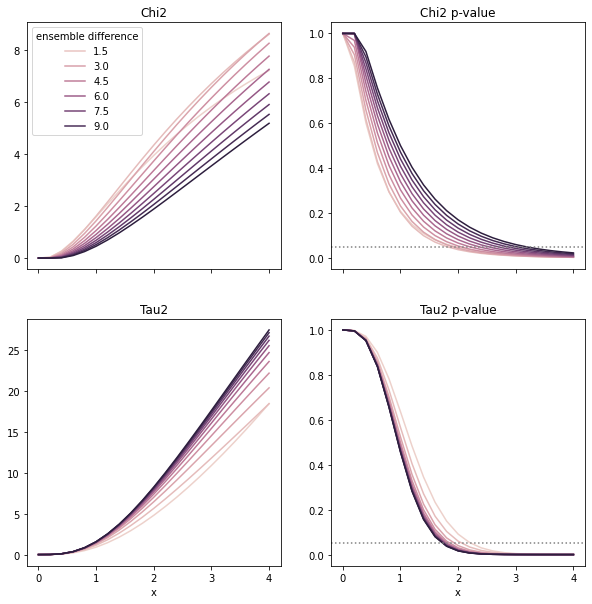

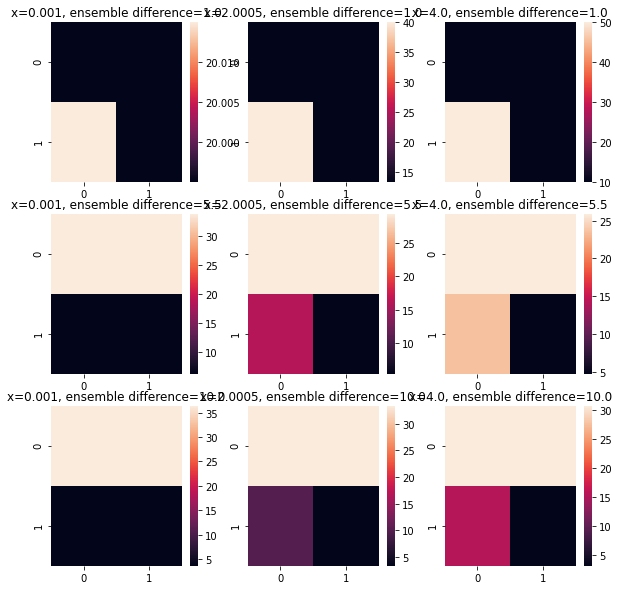

In [82]:
compare(ep.binspace(0.001,4,x_points), ep.binspace(1,10,10), weighted_hist, 'ensemble difference', flat_weights=True)

Interestingly, you can also "turn off" this behaviour with Chi2 also. In the first example we normalise the total count of all observations, because Chi2 is sensitive to the total number of observations. However, if we no longer do this, the increase in the number of total observations cancels out the differences between ensembles.

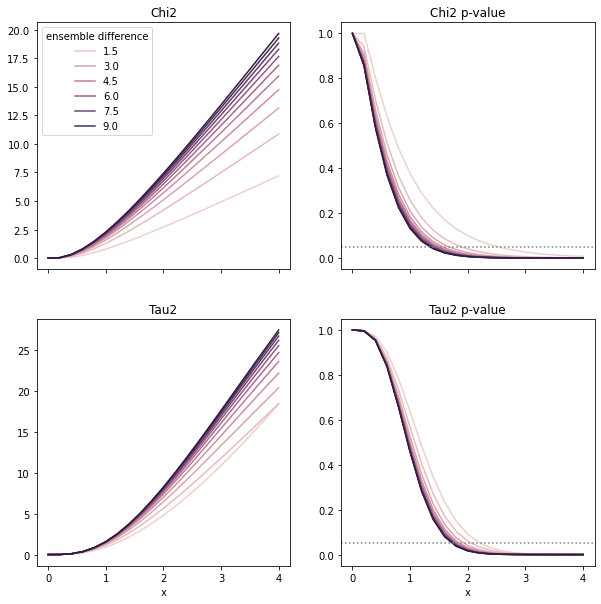

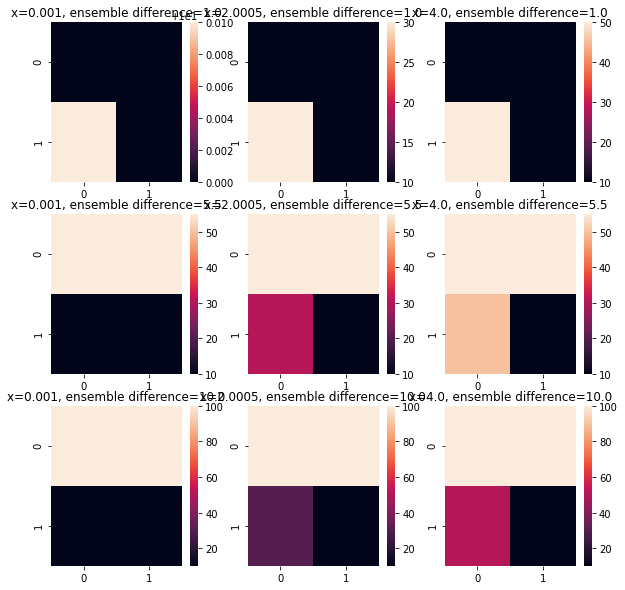

In [83]:
compare(ep.binspace(0.001,4,x_points), ep.binspace(1,10,10), weighted_hist_not_norm, 'ensemble difference', flat_weights=True)

This can be thought of conceptually as if you have an ensemble (A) with (2x) the observations as (B) with (1x), you could see this as three ensembles (Ai, Aii, B) each with equal observations. Since in this case, we would see a single outlier ensemble as making the system less complex it is appropriate to weight in this way.

# Ensembles

- First looking at a distribution which normalises the heterogenity by the number of ensembles and normalises the total number of observations for the entire distribution.
- We find, Chi2 and Tau2 lead to largely the same results, which is largely invariant to the number of ensembles (although not entirely), particularly when Tau2 is passed through chi2-distribution to find the tau-p-value.
- However, ensembles are typically used to calculate the degree's of freedom used when calculating the _p_ value for Chi2. Which ironically then causes the p-value to become very sensitive to the number of ensembles.
- Since Chi2 is typically used with 2x2 tables, this impact is minimized but is still an issue.
- When calculating Tau2, we only use the number of states (not states and ensembles like with Chi2).

In [474]:
obs = 10000
def ensemble_hists(x, ensembles):
    hist = np.array([[0.1,1+x*e/ensembles] for e in range(ensembles)])
    return hist*obs/(hist.sum())

print("%s total obs, across 2 ensembles" % ensemble_hists(0.1, 2).sum())
print(ensemble_hists(0.1, 2))
print("%s total obs, across 4 ensembles" % ensemble_hists(0.1, 4).sum())
print(ensemble_hists(0.1, 4))

10000.0 total obs, across 2 ensembles
[[ 444.44444444 4444.44444444]
 [ 444.44444444 4666.66666667]]
10000.0 total obs, across 4 ensembles
[[ 219.78021978 2197.8021978 ]
 [ 219.78021978 2252.74725275]
 [ 219.78021978 2307.69230769]
 [ 219.78021978 2362.63736264]]


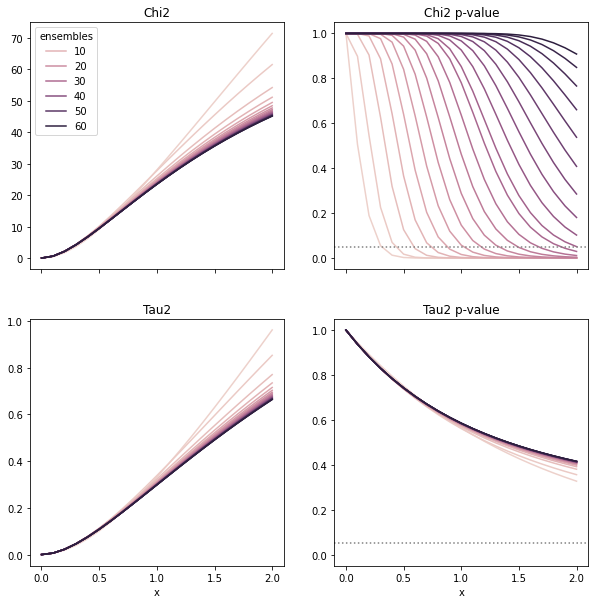

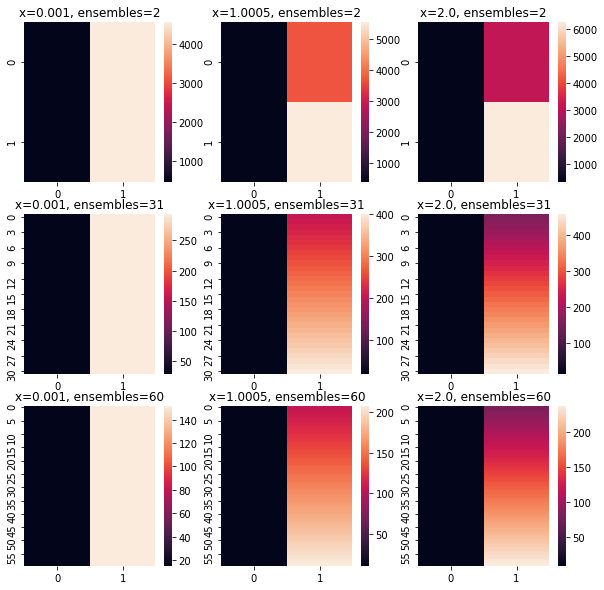

In [475]:
compare(ep.binspace(0.001,2.0,x_points), ep.binint(2,60,20), ensemble_hists, 'ensembles')

- However, it is worth noting when the number of ensembles is proportional to the number of observations, that is the number of observations per ensemble is kept constant, then the results become (broadly) invariant.
- Meaning introducing more ensembles with the same number of observations doesn't affect the results.
- In this case, since Tau2 is invariant to the total number of observations, it is invariant in this case too.

In [476]:
obs = 300
def ensemble_hists_linear(x, h):
    hist = np.array([[0.1,1+x*e/h] for e in range(h)])*obs
    return rn(hist)*obs

for i in range(1,5):
    print("%s observations per ensemble, (%s ensembles)" % (ensemble_hists_linear(0.1, i).sum()/i, i))

299.99999999999994 observations per ensemble, (1 ensembles)
300.0 observations per ensemble, (2 ensembles)
299.99999999999994 observations per ensemble, (3 ensembles)
300.0 observations per ensemble, (4 ensembles)


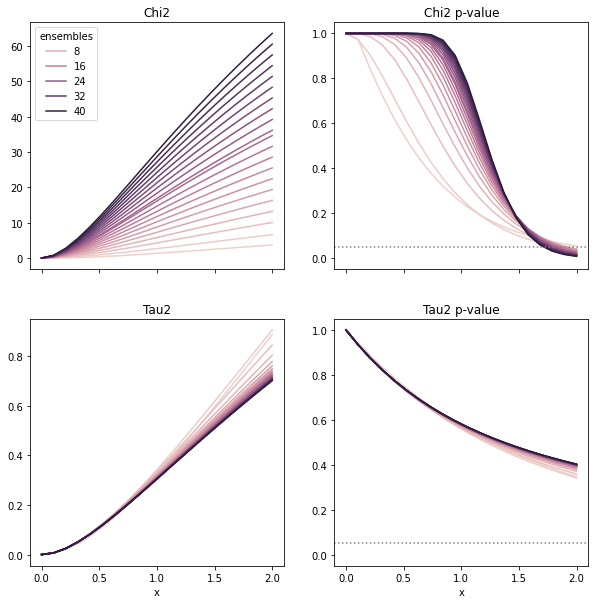

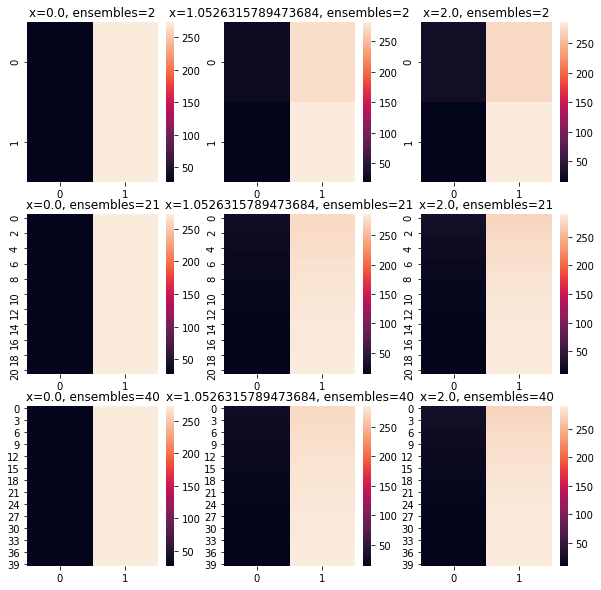

In [477]:
compare(np.linspace(0,2,x_points), ep.binint(2,40,20), ensemble_hists_linear, 'ensembles')

In [478]:
def uniform_ensembles(x, h):
    hist = np.array([[0.1,1+x*np.round((i+1)/h)] for i in range(h)])
    return rn(hist)*obs

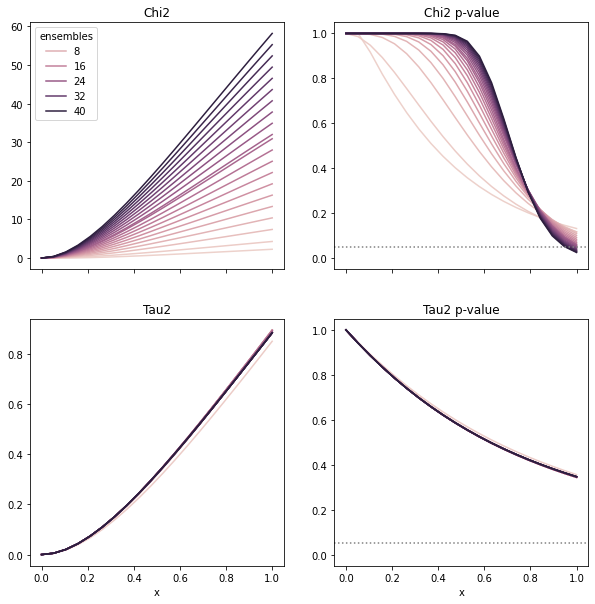

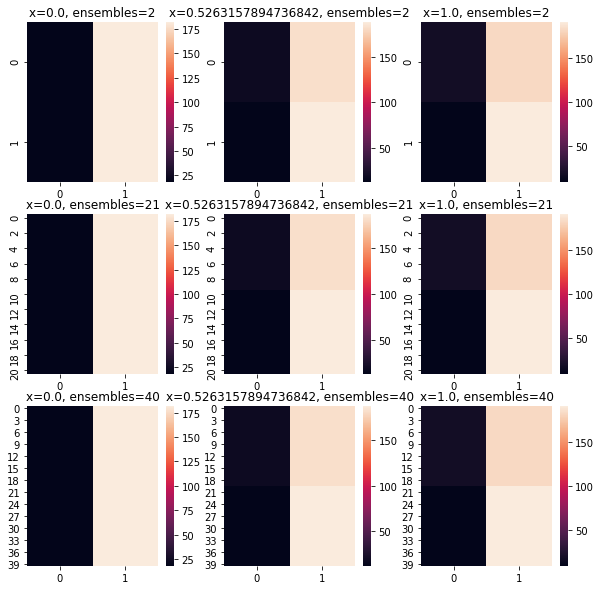

In [479]:
obs = 200
compare(np.linspace(0,1,x_points), ep.binint(2,40,20), uniform_ensembles, 'ensembles')

# States

### Invariance to states

- Taking a distribution which is exactly the same, but cutting it into finer parts
- We see Chi2 is invariant, but the chi2 distribution skews the results, where it's the observations it actually needs to account for
- While Tau2 is also invariant, but where we don't use the chi2 distribution states parameter, meaning it stays invariant

In [10]:
def states_hist_uniform(x, states):
    return rn([
        np.ones(states*2),
        np.concatenate([np.ones(states)*(1-x), np.ones(states)*x]),
    ])*100

# normalised number of observations
# effectively taking a [p,q] state and splitting it into [p/2,p/2,q/2,q/2] etc
print(state_hist_uniform(0.5,2), state_hist_uniform(0.5,2).sum())
print(state_hist_uniform(0.5,4), state_hist_uniform(0.5,4).sum())

[[50. 50.]
 [60. 40.]] 200.0
[[25. 25. 25. 25.]
 [30. 30. 20. 20.]] 200.0


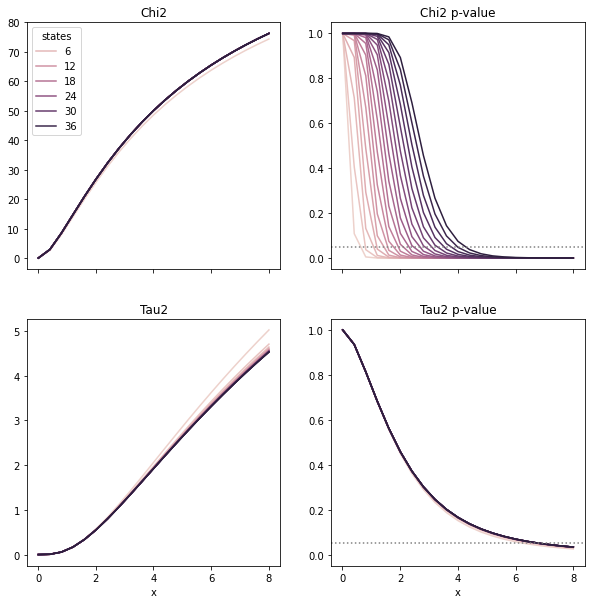

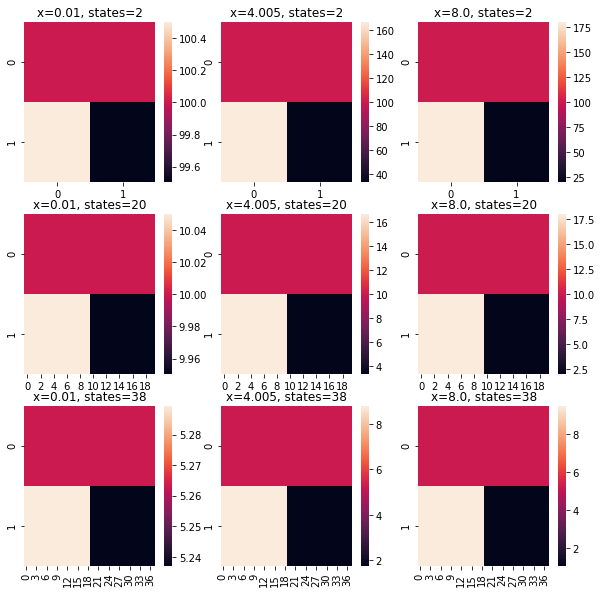

In [468]:
compare(ep.binspace(0.01,8.0,x_points), range(2,40,2), state_hist_uniform, 'states')

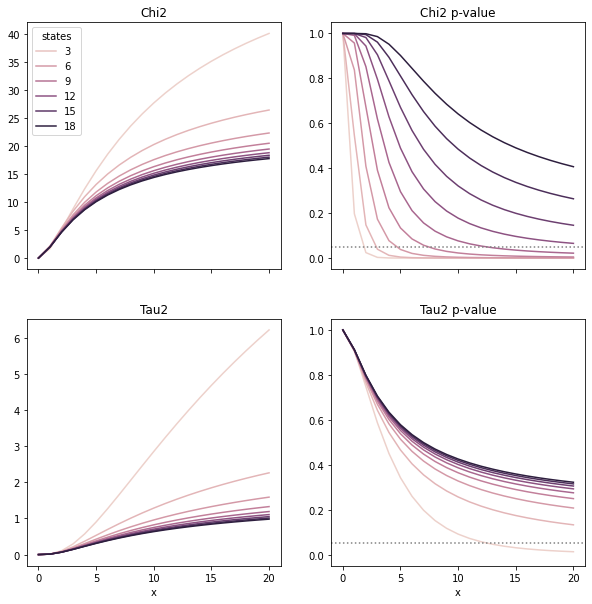

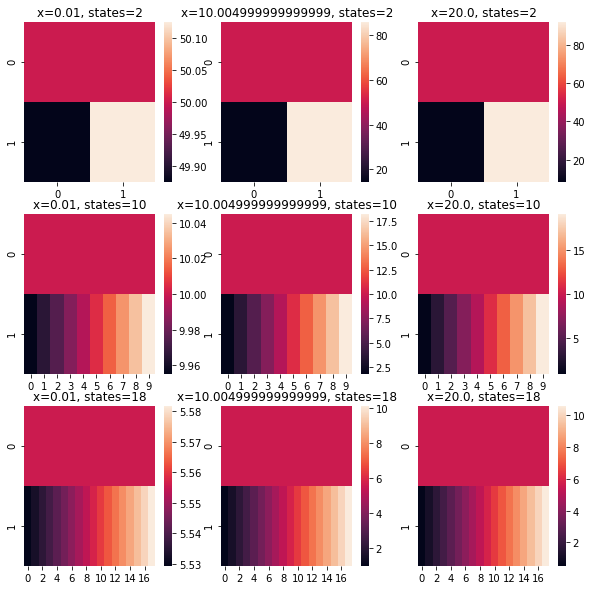

In [492]:
compare(ep.binspace(0.01,20.0,x_points), range(2,20,2), lambda x,h: rn([np.ones(h), [1+x*k/h for k in range(h)]])*100, 'states')

### Maximum entropy

- What happens as you add more states, but the maximum entropy is repeatedly found

In [483]:
# Here it's designed so that the more states the smaller the difference in x
# Which is reflected in both, but more amplified with Ce
def state_hist(x, states):
    arr = np.zeros(states*2)
    arr[0] = x
    arr[-1] = 1-x
    return rn([np.ones(states*2),arr])*100

print(state_hist(0.5,1))
print(state_hist(0.5,2))
print(state_hist(0.5,3))

[[50. 50.]
 [50. 50.]]
[[25. 25. 25. 25.]
 [50.  0.  0. 50.]]
[[16.66666667 16.66666667 16.66666667 16.66666667 16.66666667 16.66666667]
 [50.          0.          0.          0.          0.         50.        ]]


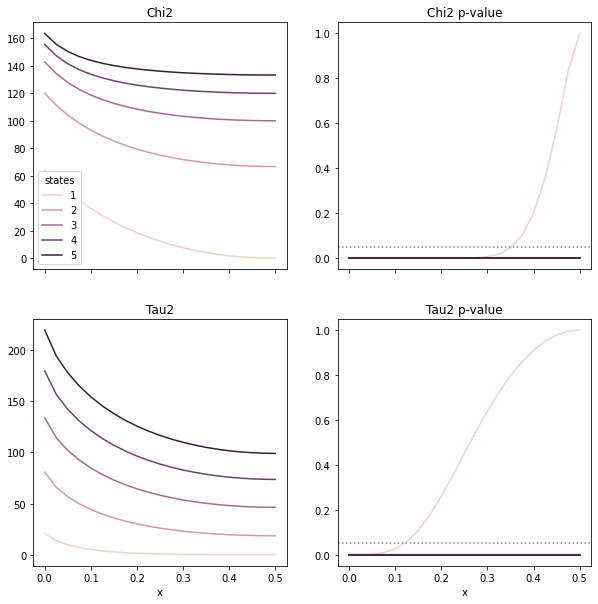

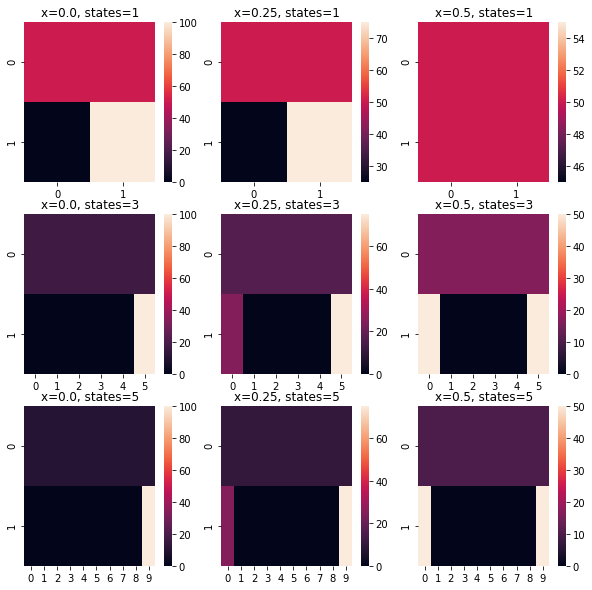

In [484]:
compare(ep.binspace(0.0,0.5,x_points), ep.binint(1,5,10), state_hist, 'states')

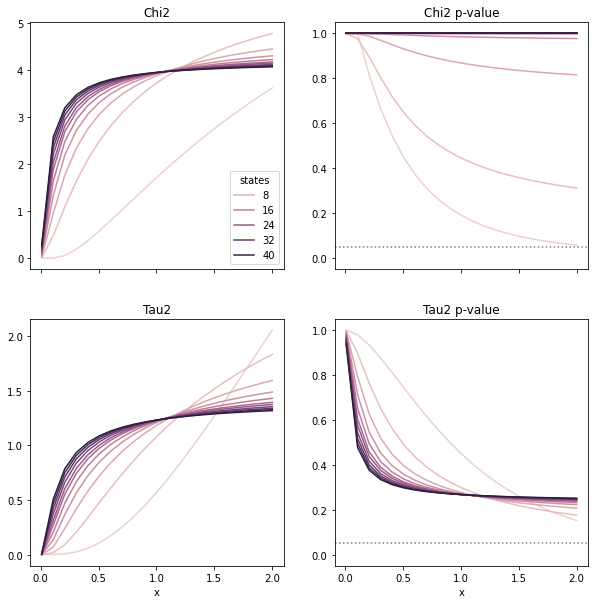

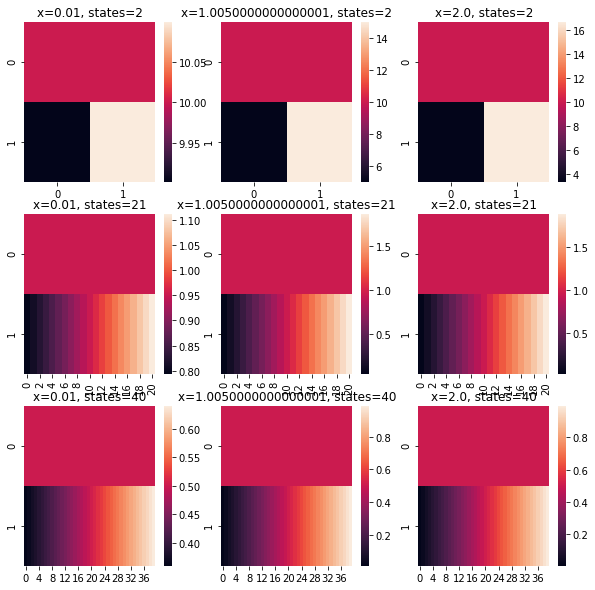

In [481]:
compare(ep.binspace(0.01,2.0,x_points), ep.binint(2,40,10), lambda x,h: rn([np.ones(h),[0.5+x*k for k in range(h)]])*20, 'states')

The fewer states you have, the higher the expected entropy of the variant distribution. Since this is an approximation. By definition the representation with these many states is the lowest possible (continous) entropy you have. Therefore the more states you have (although this is higher discrete entropy) it represents still the lower bound of possible entropy states.

Therefore the more states you have, the more confidence in the distribution you have. Therefore the lower complexity it should have. Therefore lower states should present as heterogenious faster than higher states.

Which is what we see with both models.

- Here when we normalise for the number of observations, we see Chi2 doesn't actually care about the number of states (degrees of freedom) it cares about the number of observations, of which degree's of freedom is a proxy.

- Leading to here fewer states having a higher heterogenity, even though the absolute difference between these distributions is none.

- While Ce*states compensates for the number of states, so that once it's transformed to _p_ it still suffers from some difference, which disappears at the point of significance _p = 0.05_.